In [2]:
import os
import sys

import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [3]:
# Step 1: Data Collection
train_df = pd.read_csv('datasets/property_data.csv')
train_df.head()

,Price,NumberOfRooms,District,YearOfConstruction,Floor,Area,Link
0,15000000,1,Жетысуский,1976,2,30.7,/a/show/698323887
1,69000000,5,Наурызбайский,2008,4,150,/a/show/696236386
2,70000000,3,Бостандыкский,2015,12,111.5,/a/show/692913945
3,71000000,4,Алатауский,2024,11,118,/a/show/699050320
4,34400000,2,Наурызбайский,2021,15,59.4,/a/show/697798369


In [4]:
train_df.District.value_counts()

District
Бостандыкский    460
Ауэзовский       287
Алмалинский      252
Алатауский       245
Наурызбайский    209
Медеуский        174
Турксибский      167
Жетысуский       127
Алматы            44
Алматинская       37
Name: count, dtype: int64

In [5]:
train_df.sample(5)

,Price,NumberOfRooms,District,YearOfConstruction,Floor,Area,Link
310,от17200000,1,Алматинская,2024,43,совмещенный,/a/show/696340595
1729,63000000,3,Ауэзовский,2006,1,89.4,/a/show/696840789
855,от81432960,2,Бостандыкский,2025,92.96,2,/a/show/694723351
638,24500000,2,Жетысуский,1975,4,45.5,/a/show/696102217
327,от14706000,1,Алматинская,2025,34.04,совмещенный,/a/show/693821616


### Drop unnecessary columns

In [6]:
print(f'train_df shape: {train_df.shape}')
drop_cols = ['Link']
train_df.drop(drop_cols, axis=1, inplace=True)
print(f'train_df shape after: {train_df.shape}')

train_df shape: (2002, 7)
train_df shape after: (2002, 6)


### Check NaNs

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Price               2002 non-null   object
 1   NumberOfRooms       2002 non-null   int64 
 2   District            2002 non-null   object
 3   YearOfConstruction  2002 non-null   object
 4   Floor               2002 non-null   object
 5   Area                2002 non-null   object
dtypes: int64(1), object(5)
memory usage: 94.0+ KB


In [8]:
train_df.isna().sum()

Price                 0
NumberOfRooms         0
District              0
YearOfConstruction    0
Floor                 0
Area                  0
dtype: int64

Here I convert all columns (except District) to integer, and delete those that cannot be converted. Just the data that could not be converted is the lost Data. This happened because during parsing, some ads from krisha.kz differed from the template, so the ad was parsed instead of prices, the number of floors of the apartment instead of area, and so on. Since they cannot be restored, I decided to delete them. After cleaning the data, we see that we still have 1600+ rows from the original 2000


In [9]:
train_df["Price"] = pd.to_numeric(train_df["Price"], errors='coerce')
train_df.dropna(subset=["Price"], inplace=True)


train_df["NumberOfRooms"] = pd.to_numeric(train_df["NumberOfRooms"], errors='coerce')
train_df.dropna(subset=["NumberOfRooms"], inplace=True)


train_df["YearOfConstruction"] = pd.to_numeric(train_df["YearOfConstruction"], errors='coerce')
train_df.dropna(subset=["YearOfConstruction"], inplace=True)


train_df["Floor"] = pd.to_numeric(train_df["Floor"], errors='coerce')
train_df.dropna(subset=["Floor"], inplace=True)

train_df["Area"] = pd.to_numeric(train_df["Area"], errors='coerce')
train_df.dropna(subset=["Area"], inplace=True)

types = {"Price": int, "NumberOfRooms": int, "District": str, "YearOfConstruction": int,
         "Floor": int, "Area": float}
train_df = train_df.astype(types)

train_df.head()


,Price,NumberOfRooms,District,YearOfConstruction,Floor,Area
0,15000000,1,Жетысуский,1976,2,30.7
1,69000000,5,Наурызбайский,2008,4,150.0
2,70000000,3,Бостандыкский,2015,12,111.5
3,71000000,4,Алатауский,2024,11,118.0
4,34400000,2,Наурызбайский,2021,15,59.4


In [10]:
print("Shape after cleaning data: ", train_df.shape)

Shape after cleaning data:  (1604, 6)


<Axes: >

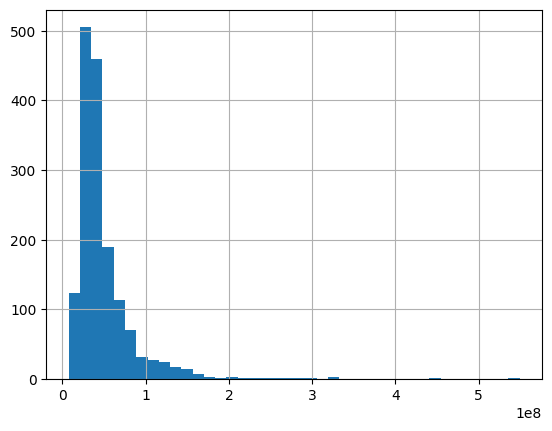

In [11]:
train_df.Price.hist(bins=40)

### Encoding object (string) dtype --> numerical (float, int)

In [12]:
train_df

,Price,NumberOfRooms,District,YearOfConstruction,Floor,Area
0,15000000,1,Жетысуский,1976,2,30.7
1,69000000,5,Наурызбайский,2008,4,150.0
2,70000000,3,Бостандыкский,2015,12,111.5
3,71000000,4,Алатауский,2024,11,118.0
4,34400000,2,Наурызбайский,2021,15,59.4
...,...,...,...,...,...,...
1996,34500000,2,Алмалинский,2019,13,48.5
1997,18900000,2,Бостандыкский,1986,3,37.0
1998,36500000,2,Наурызбайский,2022,1,61.0
2000,32000000,2,Бостандыкский,1967,1,37.5


In [13]:
train_df.District.value_counts()

District
Бостандыкский    367
Ауэзовский       268
Алмалинский      204
Алатауский       196
Наурызбайский    179
Турксибский      134
Медеуский        130
Жетысуский       103
Алматы            23
Name: count, dtype: int64

We see that the "Almaty" region has popped up. This happened due to the fact that krisha.kz users made an advertisement incorrectly and indicated a city instead of a region. Since this may affect the regression, I decided to remove the rows with the Almaty region, there are only 23 of them.

In [14]:
train_df[train_df["District"] == "Алматы"].index

Index([ 311,  574,  643,  700,  934,  984, 1158, 1191, 1249, 1261, 1276, 1288,
       1295, 1473, 1519, 1624, 1680, 1703, 1715, 1745, 1749, 1931, 1959],
      dtype='int64')

In [15]:
train_df.drop(labels=train_df[train_df["District"] == "Алматы"].index, axis=0, inplace=True)

In [16]:
train_df.District.value_counts()

District
Бостандыкский    367
Ауэзовский       268
Алмалинский      204
Алатауский       196
Наурызбайский    179
Турксибский      134
Медеуский        130
Жетысуский       103
Name: count, dtype: int64


Now that we only have the areas that exist in reality, we can start one hot encoding

In [17]:
train_label_enc_df = pd.get_dummies(train_df, columns=['District'])

In [18]:
train_label_enc_df.sample(5)

,Price,NumberOfRooms,YearOfConstruction,Floor,Area,District_Алатауский,District_Алмалинский,District_Ауэзовский,District_Бостандыкский,District_Жетысуский,District_Медеуский,District_Наурызбайский,District_Турксибский
174,26500000,1,2022,1,33.0,False,False,True,False,False,False,False,False
1342,60000000,3,2011,19,121.0,False,True,False,False,False,False,False,False
1951,45000000,2,1978,7,65.4,False,True,False,False,False,False,False,False
1253,41500000,2,2019,7,40.0,False,False,False,True,False,False,False,False
1430,29000000,1,2024,11,44.7,False,False,True,False,False,False,False,False


In [19]:
types = {"District_Алатауский": int, "District_Алмалинский": int, "District_Ауэзовский": int, "District_Бостандыкский": int, "District_Жетысуский": int,
         "District_Медеуский": int, "District_Наурызбайский": int, "District_Турксибский": int}
train_label_enc_df = train_label_enc_df.astype(types)
train_label_enc_df.sample(5)

,Price,NumberOfRooms,YearOfConstruction,Floor,Area,District_Алатауский,District_Алмалинский,District_Ауэзовский,District_Бостандыкский,District_Жетысуский,District_Медеуский,District_Наурызбайский,District_Турксибский
616,32500000,2,2018,9,70.0,1,0,0,0,0,0,0,0
1958,28500000,2,2017,9,45.0,0,0,1,0,0,0,0,0
1087,55000000,3,2016,6,91.6,0,1,0,0,0,0,0,0
689,45000000,2,2012,10,108.0,0,0,0,0,0,0,1,0
1569,36500000,2,2019,4,58.0,1,0,0,0,0,0,0,0



Converted new columns to int

### EDA

In [20]:
def plot_hist(df, col):
    plt.hist(df[col])
    plt.axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].mean() - df[col].std(), color='y', linestyle='dashed', linewidth=3)
    plt.axvline(df[col].mean() + df[col].std(), color='y', linestyle='dashed', linewidth=3)
    plt.show()

def plot_count_plot(df, col='None'):
    sns.countplot(df, x=col)
    plt.show()

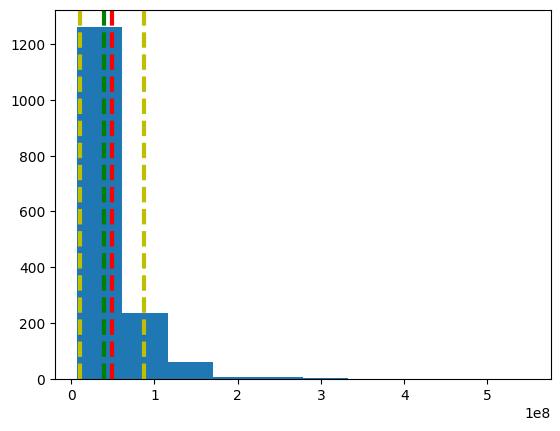

In [21]:
plot_hist(train_label_enc_df, "Price")

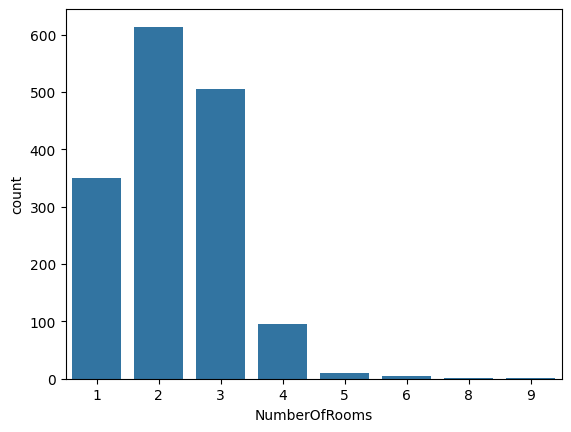

In [22]:
plot_count_plot(train_label_enc_df, "NumberOfRooms")

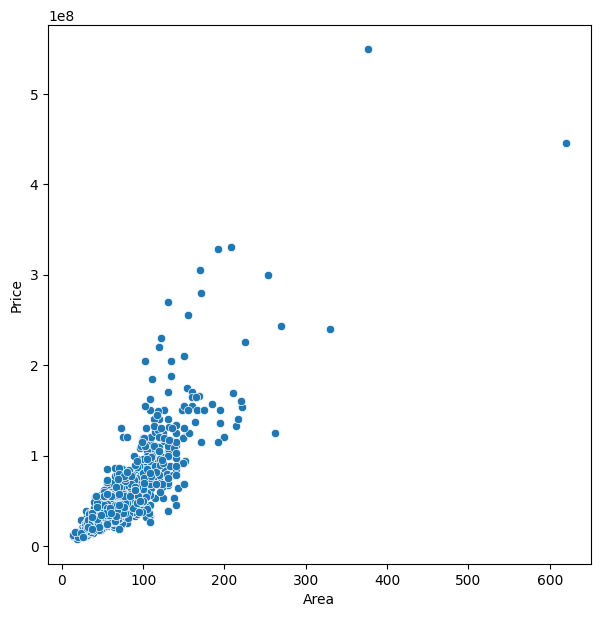

In [23]:
plt.figure(figsize=(7, 7))
sns.scatterplot(x='Area', y='Price', data=train_label_enc_df)
plt.show()


Based on the graph above, we see a positive correlation between area and price for apartments

Performing EDA...


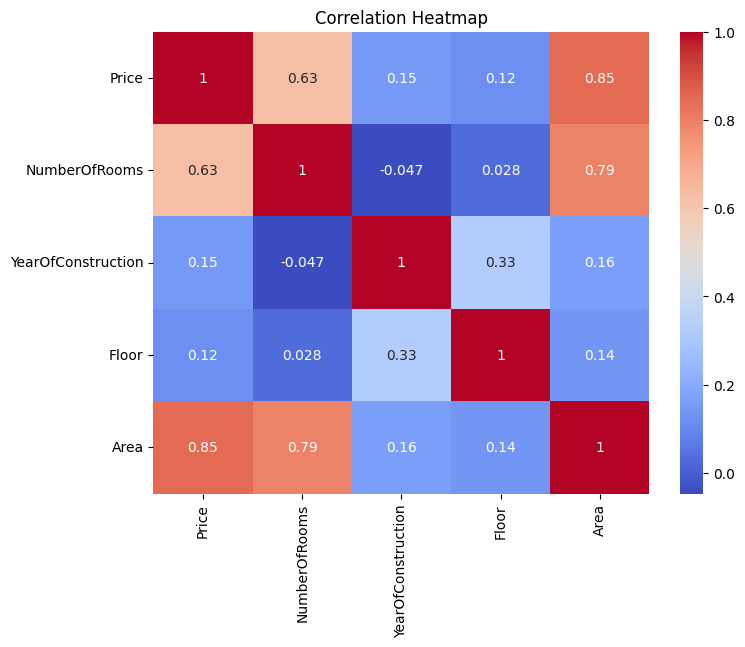

In [24]:
# Step 3: EDA
print("Performing EDA...")
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[["Price", "NumberOfRooms", "YearOfConstruction", "Floor", "Area"]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Conclusion from EDA:


1. Correlation between price and area - +0.85
2. Correlation between price and number of rooms - +0.65
3. Correlation between price and year of construction - +0.15
4. Correlation between the price and floor of the apartment - +0.12


In [25]:
train_label_enc_df.head()

,Price,NumberOfRooms,YearOfConstruction,Floor,Area,District_Алатауский,District_Алмалинский,District_Ауэзовский,District_Бостандыкский,District_Жетысуский,District_Медеуский,District_Наурызбайский,District_Турксибский
0,15000000,1,1976,2,30.7,0,0,0,0,1,0,0,0
1,69000000,5,2008,4,150.0,0,0,0,0,0,0,1,0
2,70000000,3,2015,12,111.5,0,0,0,1,0,0,0,0
3,71000000,4,2024,11,118.0,1,0,0,0,0,0,0,0
4,34400000,2,2021,15,59.4,0,0,0,0,0,0,1,0


In [26]:
# Standardizing data

standardized_data = train_label_enc_df.copy()

# Z-Score using scipy
standardized_data['NumberOfRooms'] = stats.zscore(train_label_enc_df['NumberOfRooms'])

standardized_data['YearOfConstruction'] = stats.zscore(train_label_enc_df['YearOfConstruction'])

standardized_data['Floor'] = stats.zscore(train_label_enc_df['Floor'])

standardized_data['Area'] = stats.zscore(train_label_enc_df['Area'])

standardized_data['District_Алатауский'] = stats.zscore(train_label_enc_df['District_Алатауский'])

standardized_data['District_Алмалинский'] = stats.zscore(train_label_enc_df['District_Алмалинский'])

standardized_data['District_Ауэзовский'] = stats.zscore(train_label_enc_df['District_Ауэзовский'])

standardized_data['District_Бостандыкский'] = stats.zscore(train_label_enc_df['District_Бостандыкский'])

standardized_data['District_Жетысуский'] = stats.zscore(train_label_enc_df['District_Жетысуский'])

standardized_data['District_Медеуский'] = stats.zscore(train_label_enc_df['District_Медеуский'])

standardized_data['District_Наурызбайский'] = stats.zscore(train_label_enc_df['District_Наурызбайский'])

standardized_data['District_Турксибский'] = stats.zscore(train_label_enc_df['District_Турксибский'])

In [27]:
standardized_data.head()

,Price,NumberOfRooms,YearOfConstruction,Floor,Area,District_Алатауский,District_Алмалинский,District_Ауэзовский,District_Бостандыкский,District_Жетысуский,District_Медеуский,District_Наурызбайский,District_Турксибский
0,15000000,-1.344279,-1.672685,-0.909262,-1.048606,-0.376186,-0.3849,-0.451788,-0.549824,3.788075,-0.299322,-0.357316,-0.304311
1,69000000,2.929839,0.009409,-0.407502,2.267025,-0.376186,-0.3849,-0.451788,-0.549824,-0.263986,-0.299322,2.798643,-0.304311
2,70000000,0.792780,0.377367,1.599539,1.197019,-0.376186,-0.3849,-0.451788,1.818764,-0.263986,-0.299322,-0.357316,-0.304311
3,71000000,1.861310,0.850456,1.348659,1.377669,2.658256,-0.3849,-0.451788,-0.549824,-0.263986,-0.299322,-0.357316,-0.304311
4,34400000,-0.275750,0.692760,2.352180,-0.250965,-0.376186,-0.3849,-0.451788,-0.549824,-0.263986,-0.299322,2.798643,-0.304311


### Modelling


Let's start with Decision Tree Regression


In [28]:
X = standardized_data.drop('Price', axis=1)
y = standardized_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
decision_tree_model = tree.DecisionTreeRegressor()
decision_tree_model = decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)

print('r2_score for Decision Tree : ', r2_score(y_test, decision_tree_predictions))
print('mean_absolute_error for Decision Tree : ', mean_absolute_error(y_test, decision_tree_predictions))

r2_score for Decision Tree :  0.5984510511099119
mean_absolute_error for Decision Tree :  10253591.507886436


In [30]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model = random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)

print('r2_score for Random Forest : ', r2_score(y_test, random_forest_predictions))
print('mean_absolute_error for Random Forest : ', mean_absolute_error(y_test, random_forest_predictions))

r2_score for Random Forest :  0.7670712185979828
mean_absolute_error for Random Forest :  7772437.688885383


In [31]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print('r2_score for XGBoost : ', r2_score(y_test, xgb_predictions))
print('mean_absolute_error for XGBoost : ', mean_absolute_error(y_test, xgb_predictions))

r2_score for XGBoost :  0.7581350803375244
mean_absolute_error for XGBoost :  7976300.829652997


In [32]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.7560720962021309


Best R2 score for tree models came out to be  0.76 from Random Forest Model. Now let's try different regression models


Let's start with Multiple Regression

In [33]:

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('r2_score for Multiple Regression : ', r2_score(y_test, predictions))
print('mean_absolute_error for Multiple Regression : ', mean_absolute_error(y_test, predictions))

r2_score for Multiple Regression :  0.7334332508848325
mean_absolute_error for Multiple Regression :  9480420.534405822


Rigde Regression


In [34]:
ridge_model = linear_model.Ridge()
ridge_model = ridge_model.fit(X_train, y_train)

ridge_predictions = ridge_model.predict(X_test)

print('r2_score for Ridge Regression : ', r2_score(y_test, ridge_predictions))
print('mean_absolute_error for Ridge Regression: ', mean_absolute_error(y_test, ridge_predictions))

r2_score for Ridge Regression :  0.7389084375038684
mean_absolute_error for Ridge Regression:  9222465.40275005


Lasso Regression


In [35]:
lasso_model = linear_model.Lasso()
lasso_model = lasso_model.fit(X_train, y_train)

lasso_predictions = lasso_model.predict(X_test)

print('r2_score for Lasso Regression: ', r2_score(y_test, lasso_predictions))
print('mean_absolute_error for Lasso Regression: ', mean_absolute_error(y_test, lasso_predictions))

r2_score for Lasso Regression:  0.7390612677700154
mean_absolute_error for Lasso Regression:  9225257.648709398


C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+16, tolerance: 1.975e+14
  model = cd_fast.enet_coordinate_descent(


Elastic Net

In [36]:
elastic_net_model = linear_model.ElasticNet()
elastic_net_model = elastic_net_model.fit(X_train, y_train)

elastic_net_predictions  = elastic_net_model.predict(X_test)

print('r2_score for Elastic Net : ', r2_score(y_test, elastic_net_predictions))
print('mean_absolute_error for Elastic Net : ', mean_absolute_error(y_test, elastic_net_predictions))

r2_score for Elastic Net :  0.6525679656106556
mean_absolute_error for Elastic Net :  9927245.704125771


Support Vector Regression

In [37]:
svm_model = make_pipeline(StandardScaler(), SVR(gamma='auto'))
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

print('r2_score for Support Vector Machine : ', r2_score(y_test, svm_predictions))
print('mean_absolute_error for Support Vector Machine : ', mean_absolute_error(y_test, svm_predictions))


r2_score for Support Vector Machine :  -0.043687226334228946
mean_absolute_error for Support Vector Machine :  18158047.51441926


Neural Network

In [38]:
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
nn_predictions = regr.predict(X_test)

print('r2_score for Neural Network: ', r2_score(y_test, nn_predictions))
print('mean_absolute_error for Neural Network : ', mean_absolute_error(y_test, nn_predictions))

r2_score for Neural Network:  -1.9481599732463017
mean_absolute_error for Neural Network :  45864244.12221977


C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
for degree in range(1, 6):
  poly = PolynomialFeatures(degree=degree, include_bias=False)
  poly_features = poly.fit_transform(X_train)

  poly_reg_model = linear_model.LinearRegression()
  poly_reg_model.fit(poly_features, y_train)

  y_predicted = poly_reg_model.predict(poly.fit_transform(X_test))

  print(f"Degree - {degree}")
  print('r2_score for Polynomial Regression : ', r2_score(y_test, y_predicted))
  print('mean_absolute_error for Polynomial Regression : ', mean_absolute_error(y_test, y_predicted))

  print("\n\n")

Degree - 1
r2_score for Polynomial Regression :  0.73876666552737
mean_absolute_error for Polynomial Regression :  9285742.81865691



Degree - 2
r2_score for Polynomial Regression :  0.7969267654408849
mean_absolute_error for Polynomial Regression :  8433946.410094637



Degree - 3
r2_score for Polynomial Regression :  0.8802187180300101
mean_absolute_error for Polynomial Regression :  7695576.996845426



Degree - 4
r2_score for Polynomial Regression :  0.8517696217816433
mean_absolute_error for Polynomial Regression :  8017487.8422712935



Degree - 5
r2_score for Polynomial Regression :  -5.972276463493659
mean_absolute_error for Polynomial Regression :  27225259.538773015





In [40]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X_train)

poly_reg_model = linear_model.LinearRegression()
poly_reg_model.fit(poly_features, y_train)

y_predicted = poly_reg_model.predict(poly.fit_transform(X_test))

print(f"Degree - 3")
print('r2_score for Polynomial Regression : ', r2_score(y_test, y_predicted))
print('mean_absolute_error for Polynomial Regression : ', mean_absolute_error(y_test, y_predicted))

Degree - 3
r2_score for Polynomial Regression :  0.8802187180300101
mean_absolute_error for Polynomial Regression :  7695576.996845426


We see that Multiple, Rigde, Lasso Regressions produce r2_score around 0.74, which is quite good. For Elastic Net and Neural Network the results were worse, but for Polynomial Regression we see the highest r2_score, especially with degree of 3. Accordingly, I conclude that for this problem, the best solution is Multiple Regression with degree of 3. It gives r2_score 0.88 and MAE - 7 695 576.

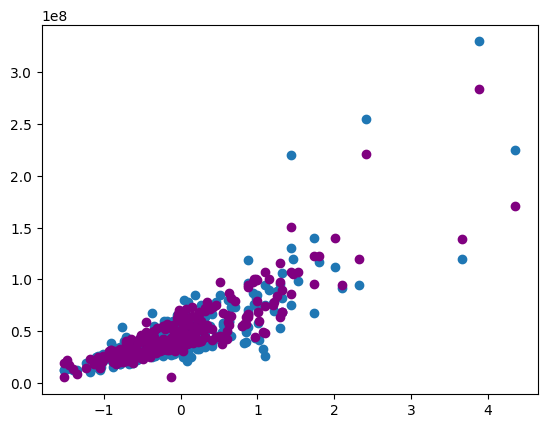

In [41]:
plt.scatter(X_test["Area"], y_test)
plt.scatter(X_test["Area"], y_predicted, color='purple')
plt.show()

Now we will try to get rid of outliers and see whether it will make metrics better

In [46]:
z_scores = (train_label_enc_df['Price'] - train_label_enc_df['Price'].mean()) / train_label_enc_df['Price'].std()

threshold = 3

train_label_enc_df = train_label_enc_df[z_scores <= threshold]


<Axes: >

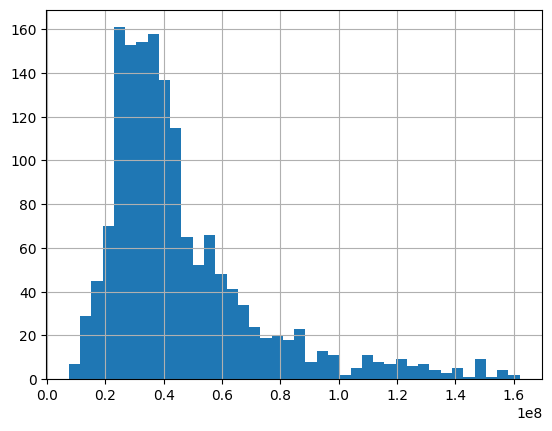

In [47]:
train_label_enc_df.Price.hist(bins=40)

In [48]:
# Standardizing data

standardized_data_no_outliers = train_label_enc_df.copy()

# Z-Score using scipy
standardized_data_no_outliers['NumberOfRooms'] = stats.zscore(train_label_enc_df['NumberOfRooms'])

standardized_data_no_outliers['YearOfConstruction'] = stats.zscore(train_label_enc_df['YearOfConstruction'])

standardized_data_no_outliers['Floor'] = stats.zscore(train_label_enc_df['Floor'])

standardized_data_no_outliers['Area'] = stats.zscore(train_label_enc_df['Area'])

standardized_data_no_outliers['District_Алатауский'] = stats.zscore(train_label_enc_df['District_Алатауский'])

standardized_data_no_outliers['District_Алмалинский'] = stats.zscore(train_label_enc_df['District_Алмалинский'])

standardized_data_no_outliers['District_Ауэзовский'] = stats.zscore(train_label_enc_df['District_Ауэзовский'])

standardized_data_no_outliers['District_Бостандыкский'] = stats.zscore(train_label_enc_df['District_Бостандыкский'])

standardized_data_no_outliers['District_Жетысуский'] = stats.zscore(train_label_enc_df['District_Жетысуский'])

standardized_data_no_outliers['District_Медеуский'] = stats.zscore(train_label_enc_df['District_Медеуский'])

standardized_data_no_outliers['District_Наурызбайский'] = stats.zscore(train_label_enc_df['District_Наурызбайский'])

standardized_data_no_outliers['District_Турксибский'] = stats.zscore(train_label_enc_df['District_Турксибский'])

In [49]:
X_no_outliers = standardized_data_no_outliers.drop('Price', axis=1)
y_no_outliers = standardized_data_no_outliers['Price']
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

In [51]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X_train_no_outliers)

poly_reg_model_no_outliers = linear_model.LinearRegression()
poly_reg_model_no_outliers.fit(poly_features, y_train_no_outliers)

y_predicted_no_outliers = poly_reg_model_no_outliers.predict(poly.fit_transform(X_test_no_outliers))

print(f"Degree - 3")
print('r2_score for Polynomial Regression : ', r2_score(y_test_no_outliers, y_predicted_no_outliers))
print('mean_absolute_error for Polynomial Regression : ', mean_absolute_error(y_test_no_outliers, y_predicted_no_outliers))

Degree - 3
r2_score for Polynomial Regression :  0.8329334061031963
mean_absolute_error for Polynomial Regression :  7234419.263665595


R2 Score is less, But MAE is better

In [52]:
random_forest_model_no_outliers = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model_no_outliers = random_forest_model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

random_forest_predictions_no_outliers = random_forest_model_no_outliers.predict(X_test_no_outliers)

print('r2_score for Random Forest : ', r2_score(y_test_no_outliers, random_forest_predictions_no_outliers))
print('mean_absolute_error for Random Forest : ', mean_absolute_error(y_test_no_outliers, random_forest_predictions_no_outliers))

r2_score for Random Forest :  0.8079168271834809
mean_absolute_error for Random Forest :  7452859.939447633


For Random Forest metrics became better, but they are not as good as Polynomial Regression
Let's try GridSearch on Random Forest


In [53]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=random_forest_model_no_outliers, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_no_outliers, y_train_no_outliers)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best R2 score:", best_score)


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best R2 score: 0.817584840717139


In [54]:
random_forest_model_best_params = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
random_forest_model_best_params = random_forest_model_best_params.fit(X_train_no_outliers, y_train_no_outliers)

random_forest_predictions_best_params = random_forest_model_best_params.predict(X_test_no_outliers)

print('r2_score for Random Forest : ', r2_score(y_test_no_outliers, random_forest_predictions_best_params))
print('mean_absolute_error for Random Forest : ', mean_absolute_error(y_test_no_outliers, random_forest_predictions_best_params))

r2_score for Random Forest :  0.8148434916371001
mean_absolute_error for Random Forest :  7400703.470932772


Stil After performing hyperparameter tuning on Random Forest model, its metrics are not as good as Polynomial Regression with 3rd degree

In [ ]:
plt.scatter(X_test_no_outliers["Area"], y_test_no_outliers)
plt.scatter(X_test_no_outliers["Area"], y_predicted_no_outliers, color='purple')
plt.show()